In [333]:
%matplotlib inline
import PIL as PIL
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from scipy import fftpack






import skimage.util
plt.rcParams["figure.figsize"] = (12,8)

In [334]:
im = PIL.Image.open('input2.bmp')
im = np.array(im)
im_ori = PIL.Image.open('input2_ori.bmp')
im_ori = np.array(im_ori)
im_R = im[:,:,0].copy()
im_G = im[:,:,1].copy()
im_B = im[:,:,2].copy()
kernel = PIL.Image.open('filter_f_test.bmp').convert('L')
kernel = np.array(kernel,dtype=np.float64)
kernel = kernel/kernel.sum()
# kernel = np.load('kernel.npy')

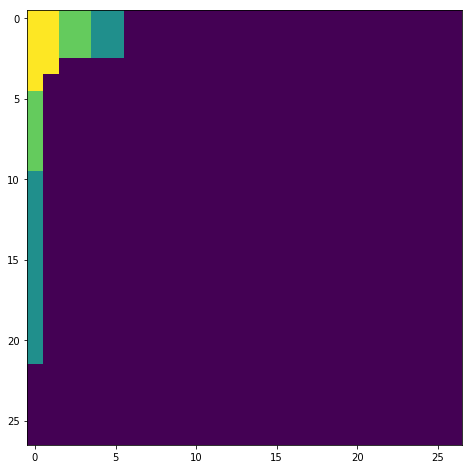

In [335]:
plt.imshow(kernel)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


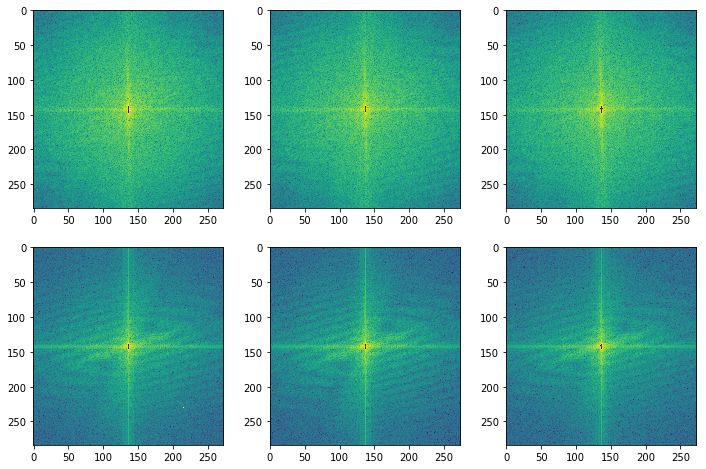

In [336]:
f,ax = plt.subplots(2,3)
for i in range(3):
    img_float32 = np.float32(im_ori[:,:,i])
    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    ax[0][i].imshow(magnitude_spectrum.astype(np.uint8))
for i in range(3):
    img_float32 = np.float32(im[:,:,i])
    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    ax[1][i].imshow(magnitude_spectrum.astype(np.uint8))   
f.show()

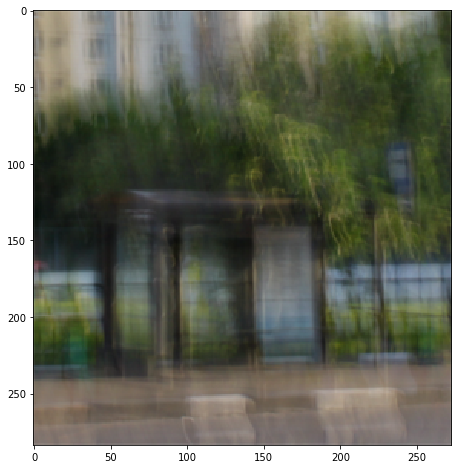

60.6115831601
58.7039272589


58.703927258931287

In [337]:
pad_width = 100
im_pad = np.zeros((im.shape[0]+pad_width*2,im.shape[1]+pad_width*2,3),np.float64)

for i in range(3):
    im_pad[:,:,i] = skimage.util.pad(im[:,:,i],mode='linear_ramp',pad_width=pad_width,end_values=0.0)
# plt.imshow(im_pad.astype(np.uint8))
# plt.show()

usewiener = False
# kernel = gkern2((im_pad.shape[0],im_pad.shape[1]),nsig=3.5)
H = np.fft.fft2(kernel,(im_pad.shape[0],im_pad.shape[1]))

# magnitude_spectrum = 20*np.log(np.abs(H))
# plt.imshow(magnitude_spectrum.astype(np.uint8),cmap='hot')
# plt.show()
# H = np.fft.fftshift(H)

def psnr(im1,im2):
    psnr = 0.0
    
    for i in range(3):
        diff = np.abs(im1[:,:,i] - im2[:,:,i])
        rmse = np.square(diff).sum()/(im2.shape[0]*im2.shape[1])
        psnr += 10*np.log10(255.0*255.0/rmse)
    print(psnr)
    return psnr

def winner(im):

    I = fftpack.fft2(im)
    H_local = H.copy()
    H_local[np.abs(H_local)<0.6] =1
    # 如果要使用溫納 註解此行
    if usewiener:
        W = np.conjugate(H_local)/(np.multiply(H_local,np.conjugate(H_local))+K)
        F = np.multiply(I,W)
        f = np.fft.ifft2(F)
        f = np.real(f)
        f[f>255] = 255.0
        f[f<0] = 0.0
        return f.astype(np.uint8)

    F = np.divide(I,H_local)
    f = np.fft.ifft2(F)
    f = np.real(f)
    f[f>255] = 255.0
    f[f<0] = 0.0
    return f.astype(np.uint8)


    

    

im_rec = np.zeros((im_pad.shape[0],im_pad.shape[1],3))
im_rec[:,:,0] = winner(im_pad[:,:,0])
im_rec[:,:,1] = winner(im_pad[:,:,1])
im_rec[:,:,2] = winner(im_pad[:,:,2])
output1 = im_rec[pad_width:-pad_width,pad_width:-pad_width,:]
PIL.Image.fromarray(output1.astype(np.uint8)).save('out2_inspec.bmp')
plt.imshow(output1.astype(np.uint8))
plt.show()


psnr(output1.astype(np.float64),im_ori.astype(np.float64))
psnr(im.astype(np.float64),im_ori.astype(np.float64))